In [62]:
################################################################################
# CSE 253: Programming Assignment 1
# Code snippet by Jenny Hamer
# Winter 2019
################################################################################
# We've provided you with the dataset in CAFE.tar.gz. To uncompress, use:
# tar -xzvf CAFE.tar.gz
################################################################################
# To install PIL, refer to the instructions for your system:
# https://pillow.readthedocs.io/en/5.2.x/installation.html
################################################################################
# If you don't have NumPy installed, please use the instructions here:
# https://scipy.org/install.html
################################################################################

from os import listdir
from PIL import Image
import numpy as np
from scipy import linalg as la
import matplotlib.pyplot as plt
# The relative path to your CAFE-Gamma dataset
data_dir = "./CAFE/"

# Dictionary of semantic "label" to emotions
emotion_dict = {"h": "happy", "ht": "happy with teeth", "m": "maudlin",
	"s": "surprise", "f": "fear", "a": "anger", "d": "disgust", "n": "neutral"}


from random import shuffle

def shuffle_n_generate_data(train, target):
    """
    Shuffle the image and labe list.
    
    Args:
        train: training image list.
        target: label list of the training images.
    Returns:
        train_new: shuffled training image list.
        target_new: shuffled label list of the training images.
    """
    length = len(train)
    train = np.array(train,'float64')
    target = np.array(target)
    ind_list = [i for i in range(length)]
    shuffle(ind_list)
    shuffle(ind_list)
    train_new  = train[ind_list,:,:]
    target_new = target[ind_list]
    return train_new, target_new

def shuffle_batch(im, lab):
    """ shuffle the training data in each batch

    Args:
        im: training dataset
        lab: training label
    Returns:
        train_new: shuffled input data
        target_new: shuffled label data
    """
    length = len(im)
    ind_list = [i for i in range(length)]
    shuffle(ind_list)
    train_new  = im[ind_list,:]
    target_new = lab[ind_list]
    return train_new, target_new

def load_data(data_dir="./CAFE/"):
    """ Load all PGM images stored in your data directory into a list of NumPy
    arrays with a list of corresponding labels.

    Args:
        data_dir: The relative filepath to the CAFE dataset.
    Returns:
        images: A list containing every image in CAFE as an array.
        labels: A list of the corresponding labels (filenames) for each image.
    """
    # Get the list of image file names
    all_files = listdir(data_dir)

    # Store the images as arrays and their labels in two lists
    images = []
    labels = []

    for file in all_files:
    # Load in the files as PIL images and convert to NumPy arrays
        if file.find('_ht') == -1 and file.find('_n') == -1:
            img = Image.open(data_dir + file)
            images.append(np.array(img))
            labels.append(file)

    print("Total number of images:", len(images), "and labels:", len(labels))

    return images, labels

def data_parse(images, labels):
    """
    Convert file name of each image into integer that represents the emotion and
    select training image list.
    Args:
        images: A list containing every image in CAFE as an array.
        labels: A list of the corresponding labels (filenames) for each image.
    Returns:
        train: A list containing training images.
        target: Alist containing integers corresponds to selected training images.
    """
    train = []
    target = []
    for i in range(len(images)):
        if labels[i].find('_ht') == -1 and labels[i].find('_n') == -1 :
            train.append(images[i])
            if labels[i].find('_h') !=-1:
                target.append(0)
            elif labels[i].find('_m') !=-1:
                target.append(1)
            elif labels[i].find('_s') !=-1:
                target.append(2)
            elif labels[i].find('_f') !=-1:
                target.append(3)
            elif labels[i].find('_a') !=-1:
                target.append(4)
            elif labels[i].find('_d') !=-1:
                target.append(5)
    return np.array(train), np.array(target)

In [63]:
def PCA(data, dims_rescaled_data=2):
    """
    returns: data transformed in 2 dims/columns + regenerated original data
    pass in: data as 2D NumPy array
    """
   
    # transpose data matrix
    AA = data.T
    # compute input data mean and standard deviation
    mean = AA.mean(axis=1)
    std = AA.std(axis=1)
    # mean center the data
    A = ((AA.T-mean)).T
    A_T = A.T
    n = A_T.shape[0] 
    # generate the covariance matrix
    sm = np.matmul((1/n)*A_T,A)
    # calculate the eigenvector and eigenvalues
    evals,ev = la.eigh(sm)
    # sort eigenvalue in decreasing order
    idx = np.argsort(evals)[::-1]
    evals = evals[idx]
    ev = ev[:,idx] ## 48*48
    result = []
    ev_r = []
    # project the mean centered onto the principal component
    for i in range(dims_rescaled_data):
        ev_i = np.matmul(A,ev[:,i])/(np.linalg.norm(np.matmul(A,ev[:,i])*np.sqrt(evals[i])))
        ev_r.append(ev_i)
        result.append(np.matmul(A_T,ev_i))
    result = np.array(result).T
    
    return result,np.array(ev_r),evals,mean,std

In [64]:
import numpy as np
images_raw, labels_raw = load_data(data_dir="./CAFE/")
images, labels = data_parse(images_raw, labels_raw)
images,labels= shuffle_n_generate_data(images, labels)
im = np.array(images[:48], 'float64')
im_re = np.reshape(im, [len(im), -1])
pca_result,evecs,evals,mean,vari = PCA(im_re, dims_rescaled_data=47)

Total number of images: 60 and labels: 60


In [65]:
def number_to_label(num):
    """
    Convert number to label
    Args:
        numbers
    Returns:
        labels
    """
    if num == 0:
        return "happy"
    if num == 1:
        return "sad"
    if num == 2:
        return "suprise"
    if num == 3:
        return "fear"
    if num == 4:
        return "angery"
    if num == 5:
        return "disgust"

def display_six_emotions(images, labels):
    """
    Select six different emotions from the images
    Args:
        images: A list containing every image in CAFE as an array.
        labels: A list of the corresponding labels (filenames) for each image.
    Returns:
        six_im: A list containing every emotion as an array
        six_label: A list containing every label of the emotions as an array
    """
    flag = [1]*6
    six_im = []
    six_label = []
    #select images with different emotion labels and store them in six_im
    for i in range(len(images)):
        if flag[labels[i]] != 0:
            six_im.append(images[i])
            flag[labels[i]] = 0
            six_label.append(number_to_label(labels[i]))
        if sum(flag)== 0:
            break
    return six_im, six_label


In [66]:
## load data
import numpy as np
images_raw, labels_raw = load_data(data_dir="./CAFE/")
images, labels = data_parse(images_raw, labels_raw)
images,labels= shuffle_n_generate_data(images, labels)
im = np.array(images[:48], 'float64')
im_re = np.reshape(im, [len(im), -1])
pca_result,evecs,evals,mean,vari = PCA(im_re, dims_rescaled_data=47)

Total number of images: 60 and labels: 60


## 2.1.(b)

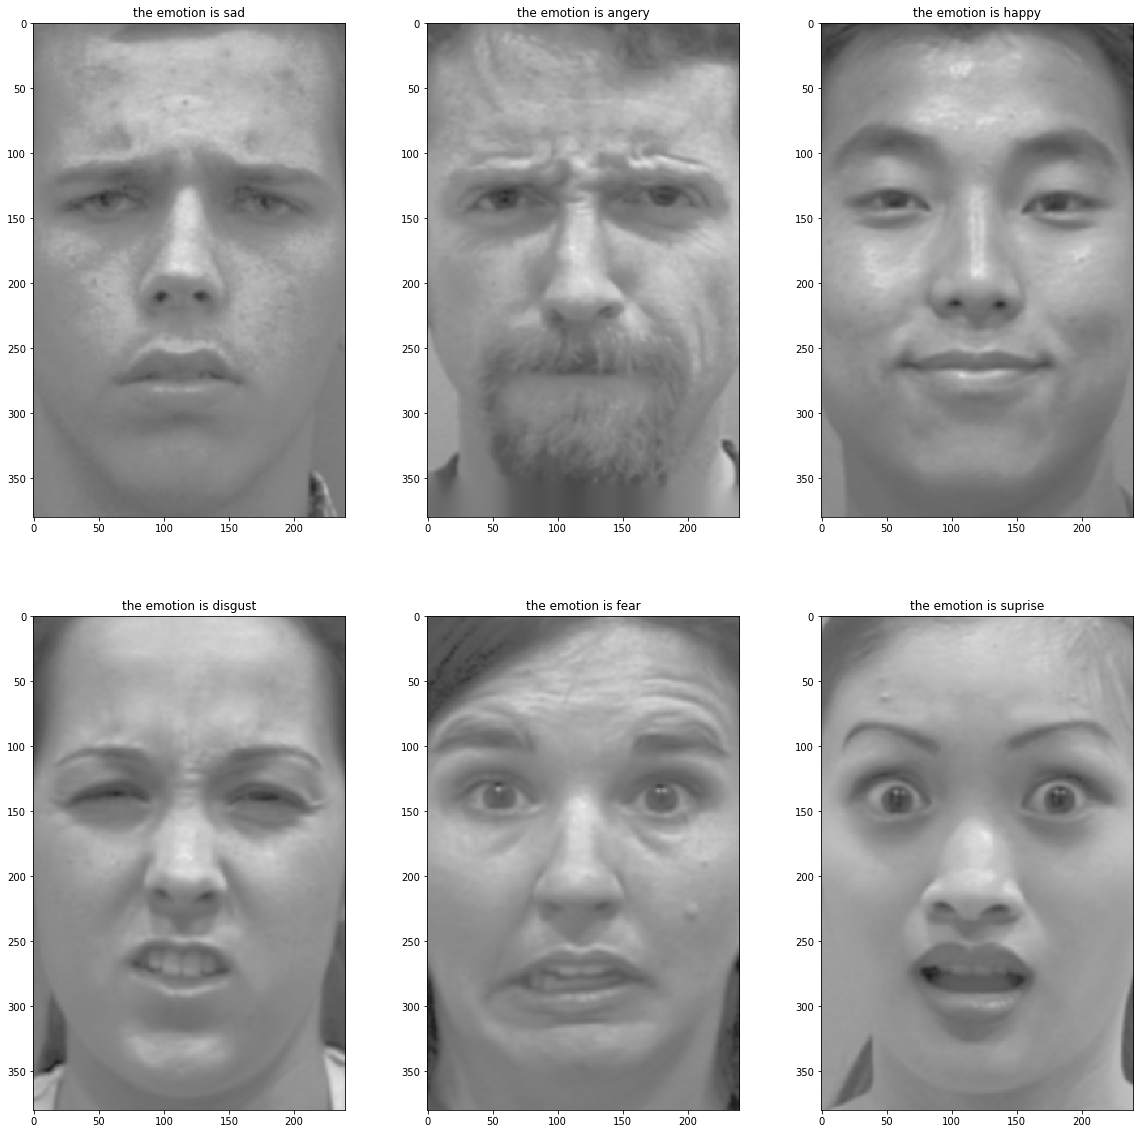

In [67]:
#Display six different emotions 
six_im,six_label = display_six_emotions(images, labels)
columns = 3
rows = 2
fig=plt.figure(figsize=(20, 20))
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(Image.fromarray(six_im[i-1]))
    plt.title("the emotion is " + str(six_label[i-1]))
plt.show()

In [68]:
print(evecs.shape)
evecs_pic = np.reshape(evecs[0:6,:],[6,380,-1])
def image_normalization(img):
    """ 
    Display the input image and optionally save as a PNG.

    Args:
        img: The NumPy array or image to display
    Returns: 
        None
    """
    # Convert img to PIL Image object (if it's an ndarray)
    if type(img) == np.ndarray:
        print("Converting from array to PIL Image")
        im = (img - img.min())*(255/(img.max()-img.min()))
        # normalize the img into 0-255
        img = Image.fromarray(im)
    # Display the image
    return img

(47, 91200)


Converting from array to PIL Image
Converting from array to PIL Image
Converting from array to PIL Image
Converting from array to PIL Image
Converting from array to PIL Image
Converting from array to PIL Image


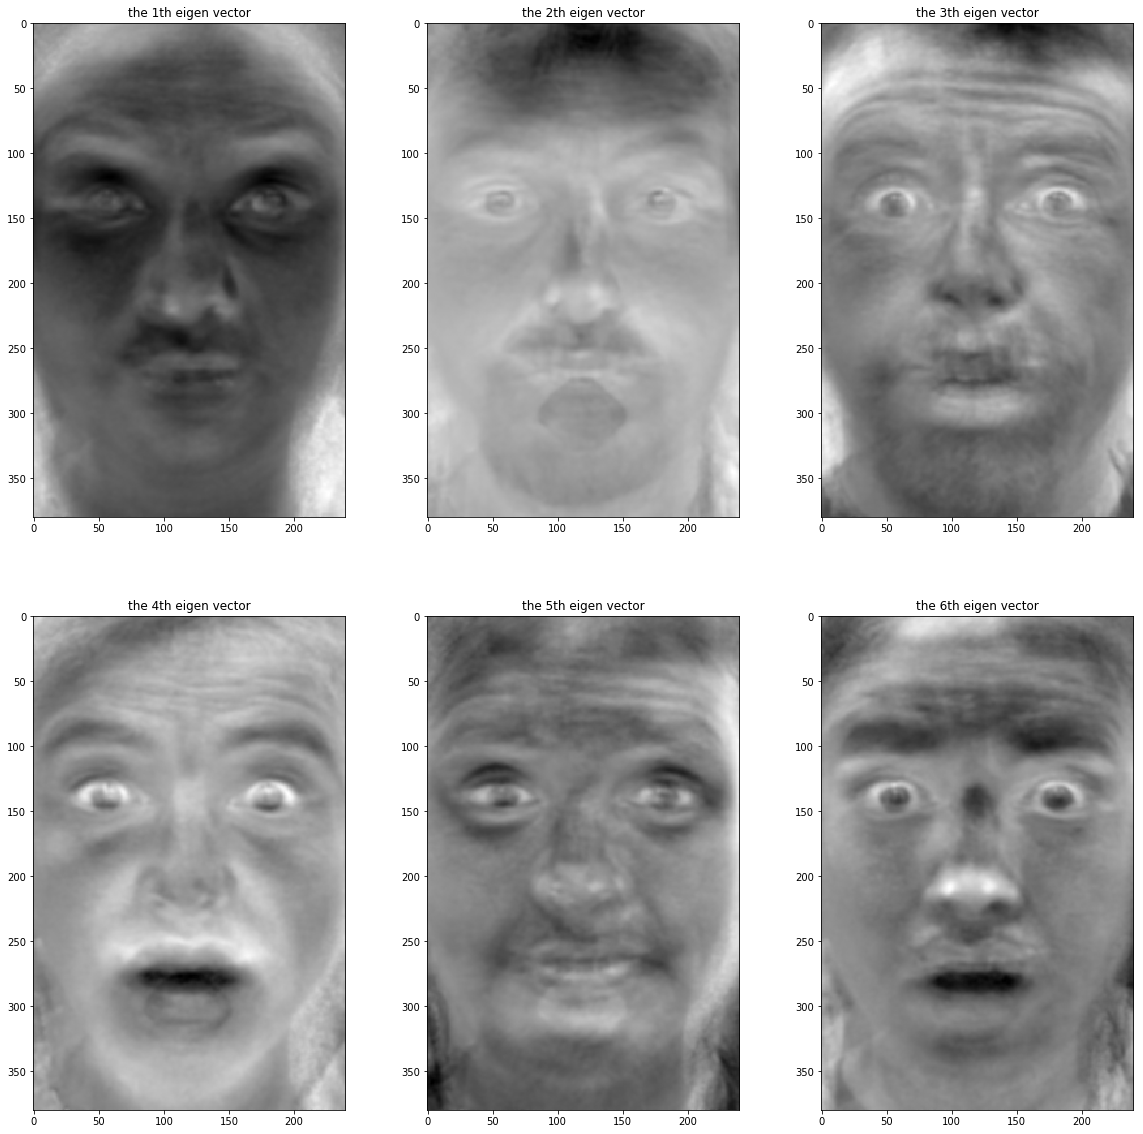

In [69]:
#display the top six eigenvectors
columns = 3
rows = 2
fig=plt.figure(figsize=(20, 20))
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(image_normalization(evecs_pic[i-1,:,:]))
    plt.title("the "+ str(i) + "th eigen vector")
plt.show()

## 2.a Logistic Regression

In [75]:
def sigmoid(x): 
    #activation function for the regression
    return 1. / (1. + np.exp(-x))
def loss(y,t):
    #loss funtion for regression
    return -1*(t*np.log(y)+(1-t)*np.log(1 - y)).mean()
def accuracy(t,p):
    #return the percentage of accurate prediction
    return 1-1.0*sum(abs(t-(p>0.5)))/len(t)
def logistic_regression(logic_in, logic_target,holdout,holdout_label, epoch, learning_rate):
    """
    Use batch gradient descent to update and find the weight, include early stop with holdout 
    set to find the best weight
    Args:
        logic_in: rescaled training data
        logic_target: labels of the images selected for training
        holdout: rescaled holdout data
        holdout_label: labels of the images selected for holdout
        epoch
        learning_rate
    Returns:
        logic_weights: weight after running all the epoches
        best_weight: early stop with holdout set that minimize the cross entropy loss
        np.array(ce_loss): cross entropy losses for 10 epoches
        np.array(holdout_loss): holdout losses for 10 epoches
    """
    ce_loss = []
    best_weight = np.zeros(logic_in.shape[1]) 
    logic_weights = np.random.rand(logic_in.shape[1])
    holdout_mark = float('inf')
    holdout_loss = []
    m = logic_in.shape[0]
    for step in range(epoch):
        logic_in,target = shuffle_batch(logic_in,logic_target)
        # compute score with new updated weight
        scores = np.dot(logic_in, logic_weights)
        # calculate the sigmoid
        predictions = sigmoid(scores)
        # compute the gradient
        gradient = 1/m * np.dot(logic_in.T, predictions-target)
        # record Cross-Entropy Error
        ce_loss.append(loss(predictions,logic_target))
        # Update weights with gradient 
        logic_weights -= learning_rate * gradient 
        # compute holdout loss
        holdout_loss_temp = loss(sigmoid(np.dot(holdout,logic_weights)),holdout_label)
        # find the weight with samllest holdout loss and store as the best weight
        if holdout_loss_temp < holdout_mark:
            holdout_mark = holdout_loss_temp
            best_weight = logic_weights
        # record holdout loss for each epoch
        holdout_loss.append(holdout_loss_temp)
    return logic_weights, best_weight, np.array(ce_loss), np.array(holdout_loss)


## 2.b

In [76]:
import math
def get_sad(images, labels):
    """
    Select sad images and their labels
    Args:
        images: A list containing every image in CAFE as an array.
        labels: A list of the corresponding labels (filenames) for each image.
    Returns:
        image_sad: A list containing all images of sad emotion as an array
    """
    image_sad = []
    for i in range(len(images)):
        if labels[i].find('_m') != -1:
            image_sad.append(images[i])
    return image_sad

def get_happy(images, labels):
    """
    Select happy images and their labels
    Args:
        images: A list containing every image in CAFE as an array.
        labels: A list of the corresponding labels (filenames) for each image.
    Returns:
        image_happy: A list containing all images of happy emotion as an array
    """
    image_happy = []
    for i in range(len(images)):
        if labels[i].find('_h') != -1:
            image_happy.append(images[i])
    return image_happy

def ramdom_pick(dataset, target):
    """
    Random Pick train validation and test dataset
    Args:
        dataset: A list images.
        target: A list of the corresponding labels for each image.
    Returns:
        train_in:  training images
        train_t: training labels
        val_in: validation images
        val_t: validation labels
        test_in: test images 
        test_t: test labels
    """
    length = len(dataset)
    num_of_valid = int(0.1*length)
    val_in = []
    val_t =[]
    test_in=[]
    test_t =[]
    train_in = []
    train_t = []
    ind_list = [i for i in range(length)]
    shuffle(ind_list)
    dataset  = dataset[ind_list,:]
    target = target[ind_list]
    flags_val = [1]*num_of_valid
    flag_test = [1]*num_of_valid
    for i in range(length):
        if flags_val[target[i]] ==1:
            val_in.append(dataset[i])
            val_t.append(target[i])
            flags_val[target[i]]=0
        elif flag_test[target[i]] ==1:
            test_in.append(dataset[i])
            test_t.append(target[i])
            flag_test[target[i]]=0
        else:
            train_in.append(dataset[i])
            train_t.append(target[i])
    return np.array(train_in),np.array(train_t),np.array(val_in),np.array(val_t),np.array(test_in),np.array(test_t)

## 2.b.(1) 10 runs

When learning rate is 0.5
Average of cross entropy loss is 
[1.15304555 1.05990168 1.11972862 1.0669564  1.03702922 0.98741663
 0.79590255 0.74062601 0.75525002 0.91680346]
Validation loss is 
[0.83991417 0.8558162  0.84715907 0.83583644 0.8179034  0.82158491
 0.79400795 0.81959782 0.81814885 0.82561145]


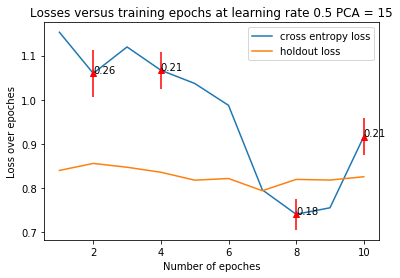

In [77]:
## initialization and set up input data
loss_train = []
loss_val = []
test_accuracy = []
test_results = []
ep = 10
lr =0.5
sad_vector = get_sad(images_raw, labels_raw)
sad =np.array(sad_vector,'float64')
happy_vector = get_happy(images_raw, labels_raw)
happy=np.array(happy_vector,'float64')
image_logistic = np.concatenate((sad,happy),axis=0)
label_logistic = np.concatenate(([0]*10,[1]*10),axis=0)
for i in range (10):##10 runs
    [image_logistic_s,label_logistic_s] = shuffle_n_generate_data(image_logistic, label_logistic)
    # split data into 80% train data, 10% holdout and 10% test data
    [train_logistic,train_label_logistic,holdout_logistic,\
     holdout_label_logistic,test_logistic,test_label_logistic]=\
    ramdom_pick(image_logistic_s, label_logistic_s)
    # perform pca on trainning data to rescale it
    [features_pca,evect,evals,train_mean,train_std] =\
        PCA(np.reshape(train_logistic,[len(train_logistic),-1]), dims_rescaled_data=15)
    # normalize holdout data and rescale it 
    holdout_logistic_b = np.reshape(holdout_logistic,[len(holdout_logistic),-1])-train_mean
    holdout_logistic_pca = np.matmul(holdout_logistic_b,evect.T)
    # perform logistic regression
    [weight,best_weight,ce_loss,holdout_loss] = \
        logistic_regression(features_pca, train_label_logistic,\
        holdout_logistic_pca, holdout_label_logistic, epoch = ep, learning_rate = lr)
    # normalize test data and rescale it 
    test_logistic_reshape = np.reshape(test_logistic,[len(test_logistic),-1])-train_mean
    test_logistic_pca = np.matmul(test_logistic_reshape,evect.T)
    # predict the test result and evaluate the prediction USING BEST WEIGHT
    test_prediction = sigmoid(np.dot(test_logistic_pca,best_weight))
    # record cross entropy loss, holdout loss and test accuracy over each run
    loss_train.append(ce_loss)
    loss_val.append(holdout_loss)
    test_accuracy.append(accuracy(test_label_logistic,test_prediction))
    test_results.append(test_prediction)

#print(loss_val)
loss_avg = np.array(loss_train).mean(axis=0)
loss_val_overall = np.array(loss_val).mean(axis=0)
loss_std = np.array(loss_train).std(axis=0)
print('When learning rate is ' + str(lr))
print('Average of cross entropy loss is ')
print(loss_avg)
print('Validation loss is ')
print(loss_val_overall)

epc = list(range(ep))
epc = [x+1 for x in epc]
plt.plot(epc, loss_avg, label = 'cross entropy loss')
plt.plot(epc, loss_val_overall, label = 'holdout loss')
plt.errorbar(2, loss_avg[1], loss_std[1]/5, c='r', linestyle='None', marker='^')
plt.text(2,loss_avg[1], '%.2f'%loss_std[1])
plt.errorbar(4, loss_avg[3], loss_std[3]/5, c='r', linestyle='None', marker='^')
plt.text(4,loss_avg[3], '%.2f'%loss_std[3])
plt.errorbar(8, loss_avg[7], loss_std[7]/5, c='r', linestyle='None', marker='^')
plt.text(8,loss_avg[7], '%.2f'%loss_std[7])
plt.errorbar(10, loss_avg[9], loss_std[9]/5, c='r', linestyle='None', marker='^')
plt.text(10,loss_avg[9], '%.2f'%loss_std[9])
plt.title('Losses versus training epochs at learning rate '+str(lr) + " PCA = 15")
plt.xlabel('Number of epoches')
plt.ylabel('Loss over epoches')
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', ncol=1)
plt.show()

## 2.b.(2)

In [78]:
print('Average of test accuracy is '+ str(np.array(test_accuracy).mean()*100)+ "%"+\
      "("+ "%.2f" %(np.array(test_accuracy).std())+")"+ " at learning rate " + str(lr)) 

Average of test accuracy is 45.0%(0.27) at learning rate 0.5


## smaller dimention reduction

When learning rate is 0.5
Average of cross entropy loss is 
[0.75307426 0.75837857 0.76108178 0.85800346 0.75948014 0.78479169
 0.71267993 0.75150234 0.73658794 0.77996147]
Validation loss is 
[0.65586105 0.65247996 0.64901125 0.64021043 0.63111927 0.62203875
 0.63239494 0.6266842  0.62723911 0.63808214]


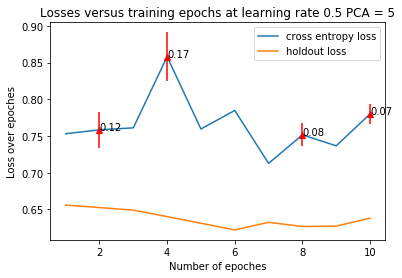

In [79]:
## initialization and set up input data
loss_train = []
loss_val = []
test_accuracy = []
test_results = []
ep = 10
lr =0.5
sad_vector = get_sad(images_raw, labels_raw)
sad =np.array(sad_vector,'float64')
happy_vector = get_happy(images_raw, labels_raw)
happy=np.array(happy_vector,'float64')
image_logistic = np.concatenate((sad,happy),axis=0)
label_logistic = np.concatenate(([0]*10,[1]*10),axis=0)
for i in range (10):##10 runs
    [image_logistic_s,label_logistic_s] = shuffle_n_generate_data(image_logistic, label_logistic)
    # split data into 80% train data, 10% holdout and 10% test data
    [train_logistic,train_label_logistic,holdout_logistic,\
     holdout_label_logistic,test_logistic,test_label_logistic]=\
    ramdom_pick(image_logistic_s, label_logistic_s)
    # perform pca on trainning data to rescale it
    [features_pca,evect,evals,train_mean,train_std] =\
        PCA(np.reshape(train_logistic,[len(train_logistic),-1]), dims_rescaled_data=5)
    # normalize holdout data and rescale it 
    holdout_logistic_b = np.reshape(holdout_logistic,[len(holdout_logistic),-1])-train_mean
    holdout_logistic_pca = np.matmul(holdout_logistic_b,evect.T)
    # perform logistic regression
    [weight,best_weight,ce_loss,holdout_loss] = \
        logistic_regression(features_pca, train_label_logistic,\
        holdout_logistic_pca, holdout_label_logistic, epoch = ep, learning_rate = lr)
    # normalize test data and rescale it 
    test_logistic_reshape = np.reshape(test_logistic,[len(test_logistic),-1])-train_mean
    test_logistic_pca = np.matmul(test_logistic_reshape,evect.T)
    # predict the test result and evaluate the prediction USING BEST WEIGHT
    test_prediction = sigmoid(np.dot(test_logistic_pca,best_weight))
    # record cross entropy loss, holdout loss and test accuracy over each run
    loss_train.append(ce_loss)
    loss_val.append(holdout_loss)
    test_accuracy.append(accuracy(test_label_logistic,test_prediction))
    test_results.append(test_prediction)

#print loss
loss_avg = np.array(loss_train).mean(axis=0)
loss_val_overall = np.array(loss_val).mean(axis=0)
loss_std = np.array(loss_train).std(axis=0)
print('When learning rate is ' + str(lr))
print('Average of cross entropy loss is ')
print(loss_avg)
print('Validation loss is ')
print(loss_val_overall)

# display plot
epc = list(range(ep))
epc = [x+1 for x in epc]
plt.plot(epc, loss_avg, label = 'cross entropy loss')
plt.plot(epc, loss_val_overall, label = 'holdout loss')
plt.errorbar(2, loss_avg[1], loss_std[1]/5, c='r', linestyle='None', marker='^')
plt.text(2,loss_avg[1], '%.2f'%loss_std[1])
plt.errorbar(4, loss_avg[3], loss_std[3]/5, c='r', linestyle='None', marker='^')
plt.text(4,loss_avg[3], '%.2f'%loss_std[3])
plt.errorbar(8, loss_avg[7], loss_std[7]/5, c='r', linestyle='None', marker='^')
plt.text(8,loss_avg[7], '%.2f'%loss_std[7])
plt.errorbar(10, loss_avg[9], loss_std[9]/5, c='r', linestyle='None', marker='^')
plt.text(10,loss_avg[9], '%.2f'%loss_std[9])
plt.title('Losses versus training epochs at learning rate '+str(lr) + " PCA = 5")
plt.xlabel('Number of epoches')
plt.ylabel('Loss over epoches')
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', ncol=1)
plt.show()

In [80]:
print('Average of test accuracy is '+ str(np.array(test_accuracy).mean()*100)+ "%"+\
      "("+ "%.2f" %(np.array(test_accuracy).std())+")"+ " at learning rate " + str(lr)) 

Average of test accuracy is 50.0%(0.22) at learning rate 0.5


## 2.b.(3)

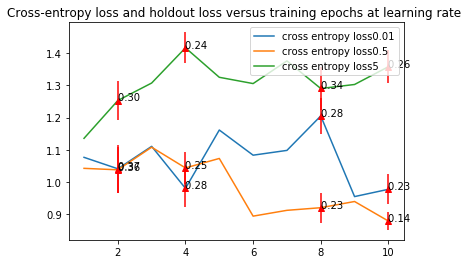

In [81]:
ce_loss_lr = []
val_loss_lr = []
std_lr=[]
lrlist = [0.01,0.5,5]
for lr in lrlist:
    sad_vector = get_sad(images_raw, labels_raw)
    sad =np.array(sad_vector,'float64')
    happy_vector = get_happy(images_raw, labels_raw)
    happy=np.array(happy_vector,'float64')
    image_logistic = np.concatenate((sad,happy),axis=0)
    label_logistic = np.concatenate(([0]*10,[1]*10),axis=0)
    loss_train = []
    loss_val = []
    test_accuracy = []
    test_results = []
    for i in range (10):
        [image_logistic_s,label_logistic_s] = shuffle_n_generate_data(image_logistic, label_logistic)
        [train_logistic,train_label_logistic,holdout_logistic,\
        holdout_label_logistic,test_logistic,test_label_logistic]=\
        ramdom_pick(image_logistic_s, label_logistic_s)
        # perform pca on trainning data to rescale it
        [features_pca,evect,evals,train_mean,train_std] =\
            PCA(np.reshape(train_logistic,[len(train_logistic),-1]), dims_rescaled_data=15)
        # normalize holdout data and rescale it 
        holdout_logistic_b = np.reshape(holdout_logistic,[len(holdout_logistic),-1])-train_mean
        holdout_logistic_pca = np.matmul(holdout_logistic_b,evect.T)
        # perform logistic regression
        [weight,best_weight,ce_loss,holdout_loss] = \
            logistic_regression(features_pca, train_label_logistic,\
                holdout_logistic_pca, holdout_label_logistic, epoch = 10, learning_rate = lr)
        # normalize test data and rescale it 
        test_logistic_reshape = np.reshape(test_logistic,[len(test_logistic),-1])-train_mean
        test_logistic_pca = np.matmul(test_logistic_reshape,evect.T)
        # predict the test result and evaluate the prediction USING BEST WEIGHT
        test_prediction = sigmoid(np.dot(test_logistic_pca,best_weight))
        # record cross entropy loss, holdout loss and test accuracy over each run
        loss_train.append(ce_loss)
        loss_val.append(holdout_loss)
        test_accuracy.append(accuracy(test_label_logistic,test_prediction))
        test_results.append(test_prediction)
        
    loss_avg = np.array(loss_train).mean(axis=0)
    std_avg = np.array(loss_train).std(axis=0)
    ce_loss_lr.append(loss_avg)
    std_lr.append(std_avg)
    val_loss_lr.append(np.array(loss_val).mean(axis=0))
ce_loss_lr = np.array(ce_loss_lr)
std_lr = np.array(std_lr)
epoch = list(range(10))
epoch = [x+1 for x in epoch]
for i in range(len(lrlist)):
    plt.plot(epoch, ce_loss_lr[i], label = 'cross entropy loss'+str(lrlist[i]))
    plt.title('Cross-entropy loss and holdout loss versus training epochs at learning rate ')
    plt.text(2,ce_loss_lr[i,1], '%.2f '%std_lr[i,1])
    plt.errorbar(2, ce_loss_lr[i,1], std_lr[i,1]/5, c='r', linestyle='None', marker='^')
    plt.text(4,ce_loss_lr[i,3], '%.2f '%std_lr[i,3])
    plt.errorbar(4, ce_loss_lr[i,3], std_lr[i,3]/5, c='r', linestyle='None', marker='^')
    plt.text(8,ce_loss_lr[i,7], '%.2f '%std_lr[i,7])
    plt.errorbar(8, ce_loss_lr[i,7], std_lr[i,7]/5, c='r', linestyle='None', marker='^')
    plt.text(10,ce_loss_lr[i,9], '%.2f '%std_lr[i,9])
    plt.errorbar(10, ce_loss_lr[i,9], std_lr[i,9]/5, c='r', linestyle='None', marker='^')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper right', ncol=1)
plt.show()

Pick the best learning rate at..0.5

## 2.c.(1)

In [82]:
import math
def get_afraid(images, labels):
    """
    get afraid emotion
    Args:
        images: A list images.
        labels: A list of the corresponding labels for each image.
    Returns:
        image_afraid:  A list images in afraid emotion
    """
    image_afraid = []
    for i in range(len(images)):
        if labels[i].find('_f') != -1:
            image_afraid.append(images[i])
    return image_afraid
def get_suprise(images, labels):
    """
    get suprise emotion
    Args:
        images: A list images.
        labels: A list of the corresponding labels for each image.
    Returns:
        image_afraid:  A list images in suprise emotion
    """
    image_suprise = []
    for i in range(len(images)):
        if labels[i].find('_s') != -1:
            image_suprise.append(images[i])
    return image_suprise


When learning rate is 0.5
Average of cross entropy loss is 
[1.10192693 1.25855662 0.97896429 0.9899687  1.0245034  1.02706216
 0.8352795  0.93357035 0.88478287 0.84920493]
Validation loss is 
[0.85307261 0.83873411 0.81368132 0.81794611 0.80559983 0.79934572
 0.8098463  0.82416705 0.81589154 0.77269599]


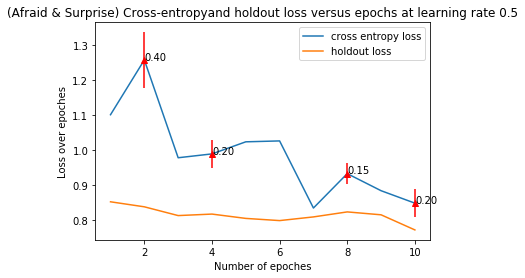

In [83]:
afraid_vector = get_afraid(images_raw, labels_raw)
#convert to numpy array
afraid =np.array(afraid_vector,'float64')
suprise_vector = get_suprise(images_raw, labels_raw)
suprise = np.array(suprise_vector,'float64')
image_logistic = np.concatenate((afraid, suprise),axis=0)
label_logistic = np.concatenate(([0]*10,[1]*10),axis=0)
loss_train = []
loss_val=[]
test_accuracy = []
test_results = []
lr=0.5
for i in range (10):
    [image_logistic_s,label_logistic_s] = shuffle_n_generate_data(image_logistic, label_logistic)
    
    [train_logistic,train_label_logistic,holdout_logistic,\
     holdout_label_logistic,test_logistic,test_label_logistic]=\
    ramdom_pick(image_logistic_s, label_logistic_s)
    
    [features_pca,evect,evals,train_mean,train_std] =\
        PCA(np.reshape(train_logistic,[len(train_logistic),-1]), dims_rescaled_data=15)
    holdout_logistic_b = np.reshape(holdout_logistic,[len(holdout_logistic),-1])-train_mean
    holdout_logistic_pca = np.matmul(holdout_logistic_b,evect.T)

    [weight,best_weight,ce_loss,holdout_loss] = \
        logistic_regression(features_pca,train_label_logistic,\
        holdout_logistic_pca,holdout_label_logistic,epoch=10, learning_rate=lr)

    test_logistic_reshape = np.reshape(test_logistic,[len(test_logistic),-1])-train_mean
    test_logistic_pca = np.matmul(test_logistic_reshape,evect.T)
    test_prediction = sigmoid(np.dot(test_logistic_pca,weight))
    
    test_result = sigmoid(np.dot(test_logistic_pca,weight))
    loss_train.append(ce_loss)
    loss_val.append(holdout_loss)
    test_accuracy.append(accuracy(test_label_logistic,test_result))
    test_results.append(test_result)
    
loss_avg = np.array(loss_train).mean(axis=0)
loss_val = np.array(np.array(loss_val).mean(axis=0))
loss_std = np.array(loss_train).std(axis=0)
print('When learning rate is ' + str(lr))
print('Average of cross entropy loss is ')
print(loss_avg)
print('Validation loss is ')
print(loss_val)

epc = list(range(10))
epc = [x+1 for x in epc]
plt.plot(epc, loss_avg, label = 'cross entropy loss')
plt.plot(epc, loss_val, label = 'holdout loss')
plt.errorbar(2, loss_avg[1], loss_std[1]/5, c='r', linestyle='None', marker='^')
plt.text(2,loss_avg[1], '%.2f'%loss_std[1])
plt.errorbar(4, loss_avg[3], loss_std[3]/5, c='r', linestyle='None', marker='^')
plt.text(4,loss_avg[3], '%.2f'%loss_std[3])
plt.errorbar(8, loss_avg[7], loss_std[7]/5, c='r', linestyle='None', marker='^')
plt.text(8,loss_avg[7], '%.2f'%loss_std[7])
plt.errorbar(10, loss_avg[9], loss_std[9]/5, c='r', linestyle='None', marker='^')
plt.text(10,loss_avg[9], '%.2f'%loss_std[9])

plt.title('(Afraid & Surprise) Cross-entropyand holdout loss versus epochs at learning rate '+str(lr))
plt.xlabel('Number of epoches')
plt.ylabel('Loss over epoches')
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', ncol=1)
plt.show()

   ## 2.C.(2)

In [84]:
print('Average of test accuracy is '+ str(np.array(test_accuracy).mean()*100)+ "%"+\
      "("+ "%.2f" %(np.array(test_accuracy).std())+")"+ " at learning rate " + str(lr)) 

Average of test accuracy is 40.0%(0.30) at learning rate 0.5


## 3.a

In [87]:
def get_data_for_softmax_re(images_sm, labels_sm):
    """
    convert the label into numbers
    Args:
        images_sm: A list images.
        labels_sm: A list of the corresponding labels for each image.
    Returns:
        train:  A list images.
        target: A list of the corresponding labels as numbers for each image
    """
    train = []
    target = []
    for i in range(len(images_sm)):
        if labels_sm[i].find('_ht') == -1 and labels_sm[i].find('_n') == -1 :
            train.append(images_sm[i])
            if labels_sm[i].find('_h') !=-1:
                target.append(0)
            elif labels_sm[i].find('_m') !=-1:
                target.append(1)
            elif labels_sm[i].find('_s') !=-1:
                target.append(2)
            elif labels_sm[i].find('_f') !=-1:
                target.append(3)
            elif labels_sm[i].find('_a') !=-1:
                target.append(4)
            elif labels_sm[i].find('_d') !=-1:
                target.append(5)
    return np.array(train), np.array(target)

def cross_entropy(a,b):
    """ Computes cross entropy between two distributions.
    Input: x: iterabale of N non-negative values
           y: iterabale of N non-negative values
    Returns: scalar
    """
    m = np.array(b).shape[0]
    n = np.array(b).shape[1]
    if np.any(a < 0) or np.any(b < 0):
        raise ValueError('Negative values exist.')

    # Force to proper probability mass function.
    a = np.array(a, dtype=np.float)
    
    # Ignore zero 'b' elements.
    #mask = b > 0
    #a = a[mask]
    #b = b[mask]
    ce = -(1.0/m/n)*np.sum(np.multiply(a,np.log(b)))
    #ce = -(1.0/m/n) * np.sum(b*np.log(a) + (1-b)*np.log(1-a))
    return ce
def softmax_1(x):
    """ Computes softmax.
    Input: x: 
    Returns: sofmax(x)
    """
    s = np.max(x, axis=1)
    s = s[:, np.newaxis] # necessary step to do broadcasting
    e_x = np.exp(x - s)
    div = np.sum(e_x, axis=1)
    div = div[:, np.newaxis] # dito
    return e_x / div
def softmax(z):
    """Compute softmax values for each sets of scores in x."""
    if z.ndim != 1:
        return (np.exp(z)/ np.array([np.sum(np.exp(z),axis=1)]).T)
    else:
        return np.exp(z)/np.sum(np.exp(z))
     
def oneHot(Y_oh,max_val):
    """ Computes onehot.
    Input: Y_oh: list of number
           max_val: The max one-hot size
    Returns: 2D list correspind to the each label's one hot representation
    """
    result_oh = []
    for i in range(len(Y_oh)):
        onehot = [0]*(int(max_val)+1)
        onehot[Y_oh[i]] = 1
        result_oh.append(onehot)
    return np.array(result_oh)

def accuracy_softmax(pred,t):
    """ Computes accuracy.
    Input: pred: prediction
           t: target
    Returns: the accuracy value
    """
    return sum(pred.argmax(axis=1)==t.argmax(axis=1))/pred.shape[0]
       
def softmax_regression(x,y,holdout,holdout_label,epoch,lr):
    """
    Use batch gradient descent to update and find the weight, include early stop with holdout 
    set to find the best weight
    Args:
        x: rescaled training data
        y: labels of the images selected for training
        holdout: rescaled holdout data
        holdout_label: labels of the images selected for holdout
        epoch
        lr: learning_rate
    Returns:
        w: weight after running all the epoches
        best_weight: early stop with holdout set that minimize the cross entropy loss
        np.array(loss_train_sm): cross entropy losses for 10 epoches
        np.array(hold_out_loss): holdout losses for 10 epoches
    """
    loss_train_sm = []
    w = np.random.rand(x.shape[1],y.max()+1)
    best_weight = np.zeros([x.shape[1],y.max()+1])
    hold_out_mark = float('inf')
    hold_out_loss = []
    max_val = y.max()
    m = x.shape[0] #The number of training examples
    for i in range(epoch):
        [x,y] = shuffle_batch(x,y)
        y_mat = oneHot(y,max_val) #One-Hot
        scores = np.dot(x,w)#Computer score
        pred = softmax(scores) #Normalize by softmax 
        l = cross_entropy(np.array(y_mat),pred) # calcucate the cross-entropy
        grad = (-1/m/max_val)*np.dot(x.T,(y_mat-pred))  #avderage gradient
        holdout_loss_temp = cross_entropy(oneHot(holdout_label,max_val),softmax(np.dot(holdout,w)))
        w = w - (grad*lr)
        ## record the best weight on validation loss
        if holdout_loss_temp < hold_out_mark:
            hold_out_mark = holdout_loss_temp
            best_weight = w
        ## record the loss
        loss_train_sm.append(l)
        hold_out_loss.append(holdout_loss_temp)
    return w, best_weight,np.array(loss_train_sm),np.array(hold_out_loss)


training loss of 50 is 
[0.50941259 0.49039901 0.47182135 0.45368705 0.4360029  0.41877494
 0.40200836 0.38570747 0.36987564 0.35451521 0.33962749 0.32521274
 0.31127018 0.29779797 0.2847933  0.27225242 0.26017066 0.24854253
 0.23736177 0.22662139 0.21631377 0.20643068 0.19696335 0.18790249
 0.17923842 0.17096101 0.16305981 0.15552408 0.14834283 0.14150485
 0.1349988  0.12881321 0.12293655 0.11735727 0.11206379 0.10704463
 0.10228834 0.09778363 0.09351931 0.08948442 0.08566816 0.08205999
 0.07864961 0.07542702 0.07238249 0.06950663 0.06679034 0.06422488
 0.06180185 0.05951319]
validation loss of 50 is 
[0.44085727 0.43318622 0.42571176 0.41843532 0.411358   0.40448057
 0.39780344 0.39132662 0.38504978 0.37897216 0.37309264 0.36740971
 0.36192151 0.35662581 0.35152007 0.34660145 0.34186681 0.33731279
 0.33293577 0.32873197 0.32469739 0.32082791 0.31711925 0.31356703
 0.31016677 0.30691394 0.30380393 0.30083211 0.29799385 0.2952845
 0.29269946 0.29023415 0.28788405 0.28564471 0.28351174 

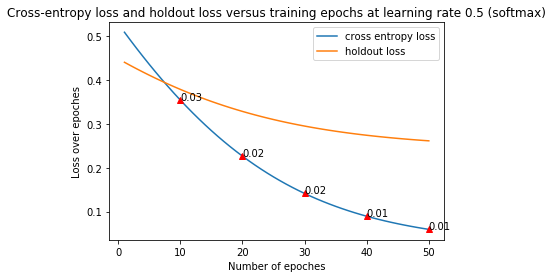

In [88]:
loss_train = []
loss_val=[]
test_accuracy = []
loss_val_avg = []
loss_avg = []
loss_std = []
for ep in [50]:    
    lr = 0.5
    for i in range(10):
        [image_softmax, label_softmax] = get_data_for_softmax_re(images_raw, labels_raw)
        [train_softmax,train_label_softmax,holdout_softmax,\
        holdout_label_softmax,test_softmax,test_label_softmax]=\
        ramdom_pick(image_softmax, label_softmax)
        
        [features_pca_sm,evect_sm,evals_sm,train_mean_sm,train_std_sm] =\
        PCA(np.reshape(train_softmax,[len(train_softmax),-1]), dims_rescaled_data=47)
        
        holdout_softmax_b = np.reshape(holdout_softmax,[len(holdout_softmax),-1])-train_mean_sm
        holdout_softmax_pca = np.matmul(holdout_softmax_b,evect_sm.T)
        
        [weight_sm,best_weight_1,ce_loss_sm,holdout_loss_sm] =\
        softmax_regression(features_pca_sm,train_label_softmax,\
                           holdout_softmax_pca,holdout_label_softmax,epoch=ep,lr=lr)
        
        test_softmax_reshape = np.reshape(test_softmax,[len(test_softmax),-1])-train_mean_sm
        test_softmax_pca = np.matmul(test_softmax_reshape,evect_sm.T)

        test_prediction = softmax(np.dot(test_softmax_pca,best_weight_1))
    
        loss_train.append(ce_loss_sm)
        loss_val.append(holdout_loss_sm)
        test_accuracy.append(accuracy_softmax(oneHot(test_label_softmax,train_label_softmax.max()),test_prediction))
    
    loss_avg = np.array(loss_train).mean(axis=0)
    loss_val_avg = np.array(loss_val).mean(axis=0)
    loss_std = np.array(loss_train).std(axis=0)
    print('training loss of ' + str(ep) + ' is ')
    print(loss_avg)
    print('validation loss of ' + str(ep) + ' is ')
    print(loss_val_avg)
epc = list(range(50))
epc = [x+1 for x in epc]
plt.plot(epc, loss_avg, label = 'cross entropy loss')
plt.plot(epc, loss_val_avg, label = 'holdout loss')
plt.text(10,loss_avg[9], '%.2f'%loss_std[9])
plt.errorbar(10, loss_avg[9], loss_std[9]/5, c='r', linestyle='None', marker='^')
plt.text(20,loss_avg[19], '%.2f'%loss_std[19])
plt.errorbar(20, loss_avg[19], loss_std[19]/5, c='r', linestyle='None', marker='^')
plt.text(30,loss_avg[29], '%.2f'%loss_std[29])
plt.errorbar(30, loss_avg[29], loss_std[29]/5, c='r', linestyle='None', marker='^')
plt.text(40,loss_avg[39], '%.2f'%loss_std[39])
plt.errorbar(40, loss_avg[39], loss_std[39]/5, c='r', linestyle='None', marker='^')
plt.text(50,loss_avg[49], '%.2f'%loss_std[49])
plt.errorbar(50, loss_avg[49], loss_std[49]/5, c='r', linestyle='None', marker='^')
plt.title('Cross-entropy loss and holdout loss versus training epochs at learning rate '+str(lr)+" (softmax)")
plt.xlabel('Number of epoches')
plt.ylabel('Loss over epoches')
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', ncol=1)
plt.show()    

In [89]:
## Report Accuracy

In [90]:
print('Average of test accuracy of softmax is '+ str(np.array(test_accuracy).mean()*100)+ "%"+\
      "("+ "%.2f" %(np.array(test_accuracy).std())+")"+ " at learning rate " + str(lr)) 

Average of test accuracy of softmax is 43.33333333333333%(0.24) at learning rate 0.5


## 3.a.(2)

In [73]:
weight_recorder=[]

for ep in [50]:    
    loss_train = []
    loss_val=[]
    test_accuracy = []
    test_result_softmax_overall = []
    test_label_overall = []
    lr = 0.5
    [image_softmax, label_softmax] = get_data_for_softmax_re(images_raw, labels_raw)
    for i in range(10):
        image_softmax,label_softmax= shuffle_n_generate_data(image_softmax, label_softmax)
        
        [train_softmax,train_label_softmax,holdout_softmax,\
        holdout_label_softmax,test_softmax,test_label_softmax]=\
        ramdom_pick(image_softmax, label_softmax)
        
        [features_pca,evect,evals,train_mean,train_std] =\
        PCA(np.reshape(train_softmax,[len(train_softmax),-1]), dims_rescaled_data=47)
        
        holdout_softmax_b = np.reshape(holdout_softmax,[len(holdout_softmax),-1])-train_mean
        holdout_softmax_pca = np.matmul(holdout_softmax_b,evect.T)
        
        [weight,best_weight, ce_loss,holdout_loss] =\
        softmax_regression(features_pca,train_label_softmax,\
                           holdout_softmax_pca,holdout_label_softmax,epoch=ep,learningRate=lr)
        weight_recorder = best_weight
        test_softmax_reshape = np.reshape(test_softmax,[len(test_softmax),-1])-train_mean
        test_softmax_pca = np.matmul(test_softmax_reshape,evect.T)
        test_prediction = softmax(np.dot(test_softmax_pca,best_weight))
    
        loss_train.append(ce_loss)
        loss_val.append(holdout_loss)
        test_accuracy.append(accuracy_softmax(oneHot(test_label_softmax,train_label_softmax.max()),test_prediction))
        
        test_result_softmax_overall.append(test_prediction)
        test_label_overall.append(oneHot(test_label_softmax,train_label_softmax.max()))
        

In [74]:
def cal_confusion_matrix(t,p):
    
    t = np.array(t)
    p = np.array(p)
    w = np.zeros([6,6])
    for i in range(t.shape[0]):
        w[t[i].argmax(axis=1),p[i].argmax(axis=1)]+=1
    return w/w.sum(axis=1)

In [75]:
confusion_matrix = cal_confusion_matrix(test_label_overall,test_result_softmax_overall)
for i in range(confusion_matrix.shape[0]):
    line = str(number_to_label(i)) + " "
    while len(line) < 9:
        line = line + " "
    for j in range(confusion_matrix.shape[1]):
        line = line + str("%.2f"%confusion_matrix[i][j] + " ")
    print(line)

happy    0.80 0.10 0.00 0.00 0.00 0.10 
sad      0.20 0.30 0.00 0.00 0.30 0.20 
suprise  0.00 0.20 0.20 0.20 0.20 0.20 
fear     0.00 0.20 0.10 0.50 0.10 0.10 
angery   0.10 0.20 0.00 0.00 0.40 0.30 
disgust  0.20 0.10 0.00 0.00 0.10 0.60 


## 3.b

In [92]:
def softmat_regression_sdg(x,y, epoch,learningRate):
    """
    Use SGD to update and find the weight, include early stop with holdout 
    set to find the best weight
    Args:
        x: rescaled training data
        y: labels of the images selected for training
        epoch
        lr: learning_rate
    Returns:
        w: weight after running all the epoches
        loss: cross entropy losses for 10 epoches
    """
    losses = []
    weight = np.zeros([x.shape[1],len(np.unique(y))])
    m = x.shape[0] 
    max_val = y.max() 
    y_mat = oneHot(y,max_val) #One hot
    ind_list = [i for i in range(m)]
    for i in range(0,epoch):
        [x,y] = shuffle_batch(x,y)
        shuffle(ind_list) # shuffle here
        for j in range(m):
            scores = np.dot(x[ind_list[j]],weight)
            prob = softmax(np.array(scores))
            grad = -1/max_val*np.outer(x[ind_list[j]],(y_mat[ind_list[j]] - prob)) ## update it every time
            weight = weight - (learningRate * grad)
        prob_overal =softmax(np.dot(x,weight)) #  training Loss over each batch 
        loss = cross_entropy(y_mat,prob_overal) 
        losses.append(loss)
    return weight, losses

In [93]:
[image_softmax, label_softmax] = get_data_for_softmax_re(images_raw, labels_raw)
image_softmax,label_softmax= shuffle_n_generate_data(image_softmax, label_softmax)
[train_softmax,train_label_softmax,holdout_softmax,\
holdout_label_softmax,test_softmax,test_label_softmax]=ramdom_pick(image_softmax, label_softmax)
        
[features_pca,evect,evals,train_mean,train_std] =\
PCA(np.reshape(train_softmax,[len(train_softmax),-1]), dims_rescaled_data=47)
        
[weight,best_weight,loss_batch,hand_out_loss] =\
softmax_regression(features_pca,train_label_softmax,\
                   holdout_softmax_pca,holdout_label_softmax,epoch=50,lr=0.5)

[weight_sdg, loss_sdg]=softmat_regression_sdg(features_pca,train_label_softmax, epoch=50,learningRate=0.5)

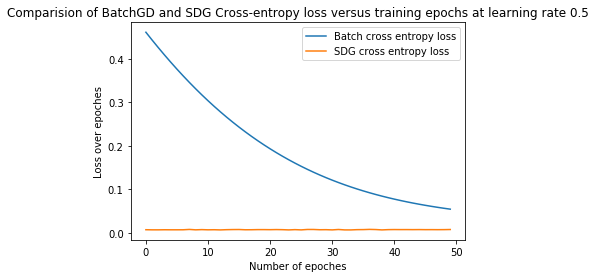

In [94]:
import matplotlib.pyplot as plt
epoch = list(range(50))
plt.plot(epoch, loss_batch, label = 'Batch cross entropy loss')
plt.plot(epoch, loss_sdg, label = 'SDG cross entropy loss')
plt.title('Comparision of BatchGD and SDG Cross-entropy loss versus training epochs at learning rate 0.5')
plt.xlabel('Number of epoches')
plt.ylabel('Loss over epoches')
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', ncol=1)
plt.show()

Converting from array to PIL Image
Converting from array to PIL Image
Converting from array to PIL Image
Converting from array to PIL Image
Converting from array to PIL Image
Converting from array to PIL Image


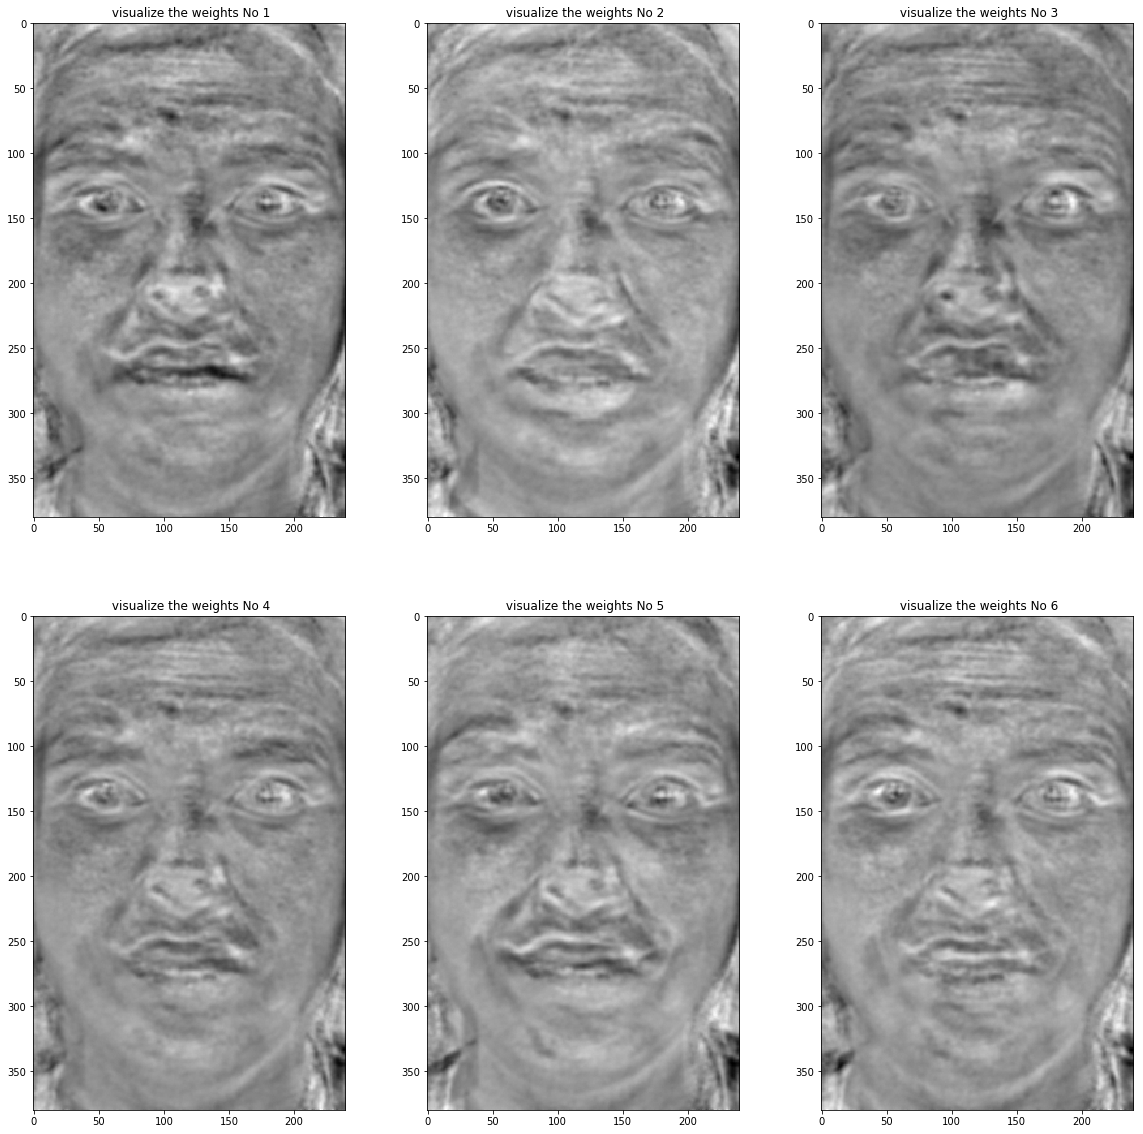

In [95]:
weight_face = np.matmul(weight_sm.T,evect)
pic = np.reshape(weight_face,[6,380,-1])
columns = 3
rows = 2
fig=plt.figure(figsize=(20, 20))
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(image_normalization(pic[i-1]))
    plt.title(" visualize the weights No " +str(i))
plt.show()

## different dimension reduction 

training loss of 50 is 
[0.35570205 0.34919583 0.34286958 0.33672128 0.33074882 0.32494996
 0.3193223  0.31386333 0.3085704  0.30344073 0.29847137 0.29365928
 0.28900126 0.28449397 0.28013399 0.27591776 0.27184164 0.2679019
 0.26409475 0.26041633 0.25686277 0.25343019 0.25011467 0.24691234
 0.24381935 0.24083191 0.23794625 0.23515869 0.23246563 0.22986355
 0.227349   0.22491864 0.22256923 0.22029763 0.21810079 0.21597577
 0.21391972 0.21192992 0.21000373 0.2081386  0.20633211 0.2045819
 0.20288573 0.20124145 0.19964697 0.19810032 0.19659959 0.19514297
 0.1937287  0.19235512]
validation loss of 50 is 
[0.33283007 0.33023054 0.32772835 0.32532171 0.32300881 0.32078781
 0.31865683 0.31661397 0.31465732 0.31278491 0.3109948  0.30928499
 0.30765347 0.30609824 0.30461724 0.30320844 0.30186979 0.30059921
 0.29939465 0.29825404 0.29717533 0.29615646 0.29519541 0.29429015
 0.29343868 0.29263905 0.2918893  0.29118754 0.29053189 0.28992052
 0.28935165 0.28882354 0.28833448 0.28788284 0.28746702 0

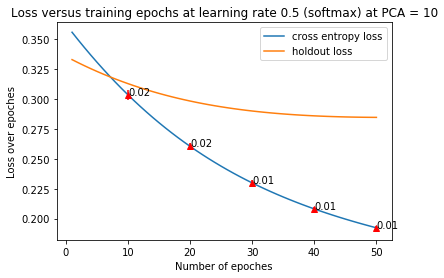

In [97]:
loss_train = []
loss_val=[]
test_accuracy = []
loss_val_avg = []
loss_avg = []
loss_std = []
for ep in [50]:    
    lr = 0.5
    [image_softmax, label_softmax] = get_data_for_softmax_re(images_raw, labels_raw)
    for i in range(10):
        [train_softmax,train_label_softmax,holdout_softmax,\
        holdout_label_softmax,test_softmax,test_label_softmax]=\
        ramdom_pick(image_softmax, label_softmax)
        
        [features_pca_sm,evect_sm,evals_sm,train_mean_sm,train_std_sm] =\
        PCA(np.reshape(train_softmax,[len(train_softmax),-1]), dims_rescaled_data=10)
        
        holdout_softmax_b = np.reshape(holdout_softmax,[len(holdout_softmax),-1])-train_mean_sm
        holdout_softmax_pca = np.matmul(holdout_softmax_b,evect_sm.T)
        
        [weight_sm,best_weight_1,ce_loss_sm,holdout_loss_sm] =\
        softmax_regression(features_pca_sm,train_label_softmax,\
                           holdout_softmax_pca,holdout_label_softmax,epoch=ep,lr=lr)
        
        test_softmax_reshape = np.reshape(test_softmax,[len(test_softmax),-1])-train_mean_sm
        test_softmax_pca = np.matmul(test_softmax_reshape,evect_sm.T)

        test_prediction = softmax(np.dot(test_softmax_pca,best_weight_1))
    
        loss_train.append(ce_loss_sm)
        loss_val.append(holdout_loss_sm)
        test_accuracy.append(accuracy_softmax(oneHot(test_label_softmax,train_label_softmax.max()),test_prediction))
    
    loss_avg = np.array(loss_train).mean(axis=0)
    loss_val_avg = np.array(loss_val).mean(axis=0)
    loss_std = np.array(loss_train).std(axis=0)
    print('training loss of ' + str(ep) + ' is ')
    print(loss_avg)
    print('validation loss of ' + str(ep) + ' is ')
    print(loss_val_avg)
epc = list(range(50))
epc = [x+1 for x in epc]
plt.plot(epc, loss_avg, label = 'cross entropy loss')
plt.plot(epc, loss_val_avg, label = 'holdout loss')
plt.text(10,loss_avg[9], '%.2f'%loss_std[9])
plt.errorbar(10, loss_avg[9], loss_std[9]/5, c='r', linestyle='None', marker='^')
plt.text(20,loss_avg[19], '%.2f'%loss_std[19])
plt.errorbar(20, loss_avg[19], loss_std[19]/5, c='r', linestyle='None', marker='^')
plt.text(30,loss_avg[29], '%.2f'%loss_std[29])
plt.errorbar(30, loss_avg[29], loss_std[29]/5, c='r', linestyle='None', marker='^')
plt.text(40,loss_avg[39], '%.2f'%loss_std[39])
plt.errorbar(40, loss_avg[39], loss_std[39]/5, c='r', linestyle='None', marker='^')
plt.text(50,loss_avg[49], '%.2f'%loss_std[49])
plt.errorbar(50, loss_avg[49], loss_std[49]/5, c='r', linestyle='None', marker='^')
plt.title('Loss versus training epochs at learning rate '+str(lr)+" (softmax) at PCA = 10")
plt.xlabel('Number of epoches')
plt.ylabel('Loss over epoches')
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', ncol=1)
plt.show()    

training loss of 50 is 
[1.4542144  1.40698917 1.36616106 1.3318973  1.3039253  1.28174643
 1.26475919 1.25230141 1.24370435 1.23835652 1.23573893 1.23542603
 1.2370704  1.24038644 1.24513828 1.25113174 1.25820832 1.2662401
 1.27512493 1.28478178 1.29514669 1.30616902 1.31780844 1.33003236
 1.34281384 1.35612989 1.36996009 1.38428539 1.39908714 1.41434631
 1.43004286 1.44615542 1.46266115 1.47953598 1.49675511 1.51429367
 1.53212744 1.5502335  1.56859074 1.58718005 1.60598439 1.62498862
 1.64417928 1.66354431 1.68307278 1.70275468 1.72258069 1.74254211
 1.76263068 1.78283864]
validation loss of 50 is 
[0.83161355 0.81676017 0.80345075 0.79173797 0.78168057 0.77333753
 0.76676018 0.76198587 0.75903578 0.75791646 0.75862344 0.76114523
 0.76546693 0.77157319 0.77944963 0.78908186 0.80045183 0.81353195
 0.82827845 0.84462622 0.86248709 0.88175234 0.90229877 0.92399667
 0.94671752 0.97034015 0.99475464 1.01986416 1.0455851  1.07184622
 1.09858722 1.1257571  1.15331255 1.18121657 1.20943716 

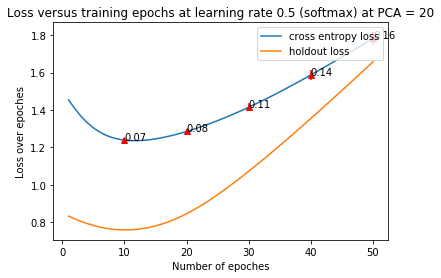

In [97]:
loss_train = []
loss_val=[]
test_accuracy = []
loss_val_avg = []
loss_avg = []
loss_std = []
for ep in [50]:    
    lr = 0.5
    [image_softmax, label_softmax] = get_data_for_softmax_re(images_raw, labels_raw)
    for i in range(10):
        [train_softmax,train_label_softmax,holdout_softmax,\
        holdout_label_softmax,test_softmax,test_label_softmax]=\
        ramdom_pick(image_softmax, label_softmax)
        
        [features_pca_sm,evect_sm,evals_sm,train_mean_sm,train_std_sm] =\
        PCA(np.reshape(train_softmax,[len(train_softmax),-1]), dims_rescaled_data=20)
        
        holdout_softmax_b = np.reshape(holdout_softmax,[len(holdout_softmax),-1])-train_mean_sm
        holdout_softmax_pca = np.matmul(holdout_softmax_b,evect_sm.T)
        
        [weight_sm,best_weight_1,ce_loss_sm,holdout_loss_sm] =\
        softmax_regression(features_pca_sm,train_label_softmax,\
                           holdout_softmax_pca,holdout_label_softmax,epoch=ep,lr=lr)
        
        test_softmax_reshape = np.reshape(test_softmax,[len(test_softmax),-1])-train_mean_sm
        test_softmax_pca = np.matmul(test_softmax_reshape,evect_sm.T)

        test_prediction = softmax(np.dot(test_softmax_pca,best_weight_1))
    
        loss_train.append(ce_loss_sm)
        loss_val.append(holdout_loss_sm)
        test_accuracy.append(accuracy_softmax(oneHot(test_label_softmax,train_label_softmax.max()),test_prediction))
    
    loss_avg = np.array(loss_train).mean(axis=0)
    loss_val_avg = np.array(loss_val).mean(axis=0)
    loss_std = np.array(loss_train).std(axis=0)
    print('training loss of ' + str(ep) + ' is ')
    print(loss_avg)
    print('validation loss of ' + str(ep) + ' is ')
    print(loss_val_avg)
epc = list(range(50))
epc = [x+1 for x in epc]
plt.plot(epc, loss_avg, label = 'cross entropy loss')
plt.plot(epc, loss_val_avg, label = 'holdout loss')
plt.text(10,loss_avg[9], '%.2f'%loss_std[9])
plt.errorbar(10, loss_avg[9], loss_std[9]/5, c='r', linestyle='None', marker='^')
plt.text(20,loss_avg[19], '%.2f'%loss_std[19])
plt.errorbar(20, loss_avg[19], loss_std[19]/5, c='r', linestyle='None', marker='^')
plt.text(30,loss_avg[29], '%.2f'%loss_std[29])
plt.errorbar(30, loss_avg[29], loss_std[29]/5, c='r', linestyle='None', marker='^')
plt.text(40,loss_avg[39], '%.2f'%loss_std[39])
plt.errorbar(40, loss_avg[39], loss_std[39]/5, c='r', linestyle='None', marker='^')
plt.text(50,loss_avg[49], '%.2f'%loss_std[49])
plt.errorbar(50, loss_avg[49], loss_std[49]/5, c='r', linestyle='None', marker='^')
plt.title('Loss versus training epochs at learning rate '+str(lr)+" (softmax) at PCA = 20")
plt.xlabel('Number of epoches')
plt.ylabel('Loss over epoches')
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', ncol=1)
plt.show()    

In [96]:
loss_train = []
loss_val=[]
test_accuracy = []
loss_val_avg = []
loss_avg = []
loss_std = []
for ep in [50]:    
    lr = 0.5
    [image_softmax, label_softmax] = get_data_for_softmax_re(images_raw, labels_raw)
    for i in range(10):
        [train_softmax,train_label_softmax,holdout_softmax,\
        holdout_label_softmax,test_softmax,test_label_softmax]=\
        ramdom_pick(image_softmax, label_softmax)
        
        [features_pca_sm,evect_sm,evals_sm,train_mean_sm,train_std_sm] =\
        PCA(np.reshape(train_softmax,[len(train_softmax),-1]), dims_rescaled_data=40)
        
        holdout_softmax_b = np.reshape(holdout_softmax,[len(holdout_softmax),-1])-train_mean_sm
        holdout_softmax_pca = np.matmul(holdout_softmax_b,evect_sm.T)
        
        [weight_sm,best_weight_1,ce_loss_sm,holdout_loss_sm] =\
        softmax_regression(features_pca_sm,train_label_softmax,\
                           holdout_softmax_pca,holdout_label_softmax,epoch=ep,lr=lr)
        
        test_softmax_reshape = np.reshape(test_softmax,[len(test_softmax),-1])-train_mean_sm
        test_softmax_pca = np.matmul(test_softmax_reshape,evect_sm.T)

        test_prediction = softmax(np.dot(test_softmax_pca,best_weight_1))
    
        loss_train.append(ce_loss_sm)
        loss_val.append(holdout_loss_sm)
        test_accuracy.append(accuracy_softmax(oneHot(test_label_softmax,train_label_softmax.max()),test_prediction))
    
    loss_avg = np.array(loss_train).mean(axis=0)
    loss_val_avg = np.array(loss_val).mean(axis=0)
    loss_std = np.array(loss_train).std(axis=0)
    print('training loss of ' + str(ep) + ' is ')
    print(loss_avg)
    print('validation loss of ' + str(ep) + ' is ')
    print(loss_val_avg)
epc = list(range(50))
epc = [x+1 for x in epc]
plt.plot(epc, loss_avg, label = 'cross entropy loss')
plt.plot(epc, loss_val_avg, label = 'holdout loss')
plt.text(10,loss_avg[9], '%.2f'%loss_std[9])
plt.errorbar(10, loss_avg[9], loss_std[9]/5, c='r', linestyle='None', marker='^')
plt.text(20,loss_avg[19], '%.2f'%loss_std[19])
plt.errorbar(20, loss_avg[19], loss_std[19]/5, c='r', linestyle='None', marker='^')
plt.text(30,loss_avg[29], '%.2f'%loss_std[29])
plt.errorbar(30, loss_avg[29], loss_std[29]/5, c='r', linestyle='None', marker='^')
plt.text(40,loss_avg[39], '%.2f'%loss_std[39])
plt.errorbar(40, loss_avg[39], loss_std[39]/5, c='r', linestyle='None', marker='^')
plt.text(50,loss_avg[49], '%.2f'%loss_std[49])
plt.errorbar(50, loss_avg[49], loss_std[49]/5, c='r', linestyle='None', marker='^')
plt.title('Loss versus training epochs at learning rate '+str(lr)+" (softmax) at PCA = 40")
plt.xlabel('Number of epoches')
plt.ylabel('Loss over epoches')
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', ncol=1)
plt.show()    

TypeError: softmax_regression() got an unexpected keyword argument 'learningRate'